In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy.ext.automap import automap_base

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# View all of the classes that automap found
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [6]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [7]:
session = Session(engine)

In [8]:
# fetch data from csv file through query

id=[]
station=[]
date=[]
prcp=[]
tobs=[]
for row in session.query(measurement.id, measurement.station, measurement.date, measurement.prcp, measurement.tobs).all():
    id.append(row[0])
    station.append(row[1])
    date.append(row[2])
    prcp.append(row[3])
    tobs.append(row[4])


# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
asc_order_date = session.query(measurement.date).order_by(measurement.date.desc())
last_date = asc_order_date.first().date
last_date

'2017-08-23'

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
twelve_month_range = dt.datetime.strptime(last_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precipitation_twelve = session.query(measurement.date, func.avg(measurement.prcp)).\
                    filter(measurement.date >= twelve_month_range).\
                    group_by(measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

prcp_df = pd.DataFrame(precipitation_twelve, columns=['date', 'prcp'])
prcp_df.set_index('date', inplace=True)
prcp_df.head()

,prcp
date,
2016-08-24,1.555000
2016-08-25,0.077143
2016-08-26,0.016667
2016-08-27,0.064000
2016-08-28,0.516667


<function matplotlib.pyplot.show(close=None, block=None)>

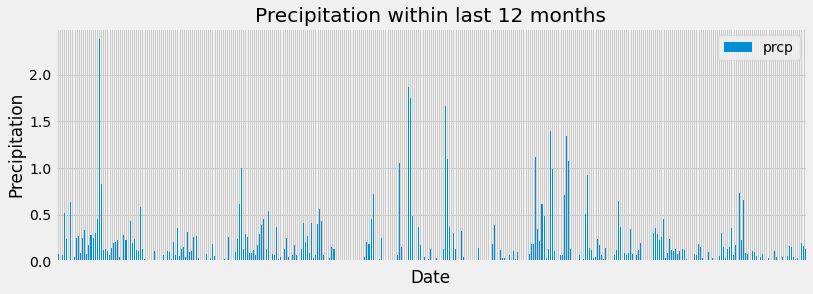

In [11]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(kind='bar', figsize=(12,4))
ax.xaxis.set_major_formatter(plt.NullFormatter())
plt.title("Precipitation within last 12 months")
plt.ylabel("Precipitation")
plt.xlabel("Date")
plt.show

In [12]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,prcp
count,365.000000
mean,0.169987
std,0.295722
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number stations in the dataset
station_list = pd.DataFrame(station, columns=['station'])
station_list.station.unique()

array(['USC00519397', 'USC00513117', 'USC00514830', 'USC00517948',
       'USC00518838', 'USC00519523', 'USC00519281', 'USC00511918',
       'USC00516128'], dtype=object)

In [14]:
## OR

station_list.describe()

,station
count,19550
unique,9
top,USC00519281
freq,2772


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_list = session.query(measurement.station, func.count(measurement.station)).\
            group_by(measurement.station).\
            order_by(func.count(measurement.station).desc()).all()

In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
top_station = station_list[0][0]
session.query(func.min(measurement.tobs), func.avg(measurement.tobs), func.max(measurement.tobs)).\
                filter(measurement.station == top_station).all()

[(54.0, 71.66378066378067, 85.0)]

In [23]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
top_station_summary = session.query(measurement.station, measurement.tobs, measurement.date).\
                filter(measurement.station == top_station).\
                filter(measurement.date >= twelve_month_range).all()
top_station_summary_df = pd.DataFrame(top_station_summary, columns=['station', 'tobs','date'])
top_station_summary_df = top_station_summary_df.set_index('station')
top_station_summary_df.head()

,tobs,date
station,,
USC00519281,77.0,2016-08-24
USC00519281,80.0,2016-08-25
USC00519281,80.0,2016-08-26
USC00519281,75.0,2016-08-27
USC00519281,73.0,2016-08-28


<function matplotlib.pyplot.show(close=None, block=None)>

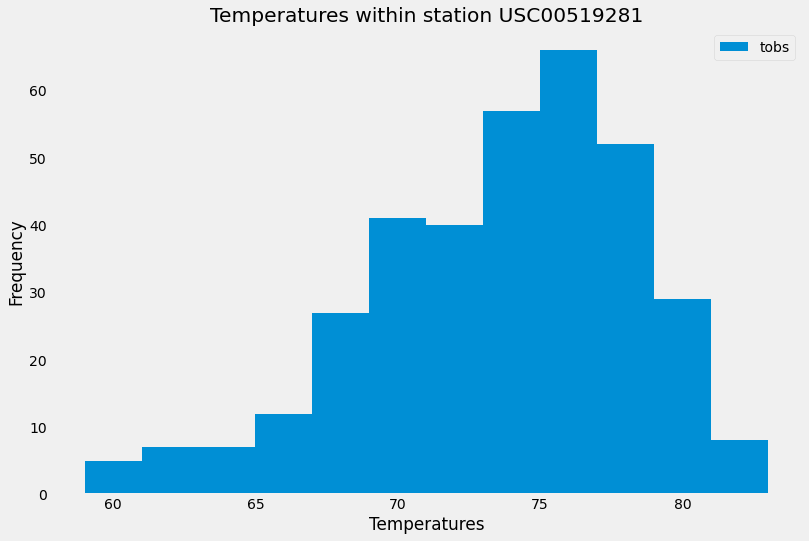

In [26]:
#latest date
top_station_summary_df.plot.hist(by='station', bins=12, figsize=(12,8))
plt.grid()
plt.title("Temperatures within station " + top_station)
plt.xlabel("Temperatures")
plt.show

# Climate App

In [51]:
from flask import Flask, jsonify
app = Flask(__name__)

In [59]:
# Homepage: List all routes that are available

@app.route("/")
def home():
    print("Server received request for 'Home' page...")
    return "Welcome to my 'Home' page!"

In [53]:
# @app.route("/precipitation")
# def precipitation():
#     last_date = dt.date(2017, 8 ,23)
#     twelve_range = last_date - dt.timedelta(days=365)

#     date_range = (session.query(measurement.date, measurement.prcp)
#                 .filter(measurement.date <= last_date)
#                 .filter(measurement.date >= twelve_range)
#                 .order_by(measurement.date).all())
    
#     precip = {date: prcp for date, prcp in date_range}
    
#     return jsonify(precip)

In [54]:
# @app.route('/stations')
# def stations():

#     station_list = session.query(station.station).all()

#     return jsonify(station_list)

In [55]:
# @app.route('/tobs') 
# def tobs():  
#     last_date = dt.date(2017, 8 ,23)
#     twelve_range = last_date - dt.timedelta(days=365)

#     prev_year = (session.query(measurement.tobs)
#                 .filter(measurement.station == 'USC00519281')
#                 .filter(measurement.date <= last_date)
#                 .filter(measurement.date >= twelve_range)
#                 .order_by(measurement.tobs).all())
    
#     return jsonify(prev_year)

In [60]:
if __name__ == '__main__':
    app.run(debug=True)

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: on


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)
 * Restarting with fsevents reloader


SystemExit: 1

# Close session

In [37]:
# Close Session
session.close()